In [ ]:
!pip install blackjax

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as t
from datetime import date
import jax
import jax.numpy as jnp
import blackjax

In [2]:
class GossetBravyiSpinChain:
  def __init__(self, number_spins, theta, p, beta=1.):
    self.number_spins = number_spins
    self.theta = theta
    self.p = p
    self.beta = beta
    self.rotation = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    local_hamiltonian_projector = np.kron(np.eye(2), self.rotation) @ ((np.array([[np.sqrt(1 - p), 0, 0, np.sqrt(p)]])).T)
    self.local_hamiltonian = local_hamiltonian_projector @ (local_hamiltonian_projector.T)

  def cost(self, data):
    @jax.jit
    def qubit_states(data):
      cc = jnp.cos(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.cos(jnp.mod(data[1:], 2 * jnp.pi))
      cs = jnp.cos(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.sin(jnp.mod(data[1:], 2 * jnp.pi))
      sc = jnp.sin(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.cos(jnp.mod(data[1:], 2 * jnp.pi))
      ss = jnp.sin(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.sin(jnp.mod(data[1:], 2 * jnp.pi))
      return jnp.array([cc, cs, sc, ss], dtype=jnp.float32)
    qs = qubit_states(data)
    return_cost = jnp.trace((qs.T) @ (self.local_hamiltonian @ qs))
    return - self.beta * return_cost


In [3]:
# global constants for sampling algorithm
DEFAULT_WARMUP_TIME = 100
DEFAULT_STEP_SIZE = 0.005 * jnp.pi

class NutsWindowAdapt:
  def __init__(self, problem_instance, initial_position, warmup=True, warmup_time=DEFAULT_WARMUP_TIME):
    self.call_cost_function = lambda x : problem_instance.cost(**x)
    self.initial_position = initial_position
    self.warmup = warmup
    self.rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

    if warmup:
      warmup_sampler = blackjax.window_adaptation(blackjax.nuts, self.call_cost_function)
      _, warmup_key, self.sample_key = jax.random.split(self.rng_key, 3)
      (self.state, self.parameters), _ = warmup_sampler.run(warmup_key, self.initial_position, num_steps=warmup_time)

  def inference_loop(self, rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

  def run(self, run_time, inverse_mass_matrix, step_size=DEFAULT_STEP_SIZE):
    if self.warmup:
      kernel = blackjax.nuts(self.call_cost_function, **self.parameters).step
      states = self.inference_loop(self.sample_key, kernel, self.state, run_time)
    else:
      nuts_sampler = blackjax.nuts(self.call_cost_function, step_size, inverse_mass_matrix)
      initial_state = nuts_sampler.init(self.initial_position)
      _, sample_key = jax.random.split(self.rng_key)
      states = self.inference_loop(sample_key, nuts_sampler.step, initial_state, run_time)
    return states

In [4]:
# constants for soft spheres
number_spins = 50
theta = 2. * np.pi / 5.
run_time = 1000

np.random.seed(0)
initial_data = 2 * np.pi * np.random.rand(number_spins)
initial_position = {"data": initial_data}
default_inverse_mass_matrix = np.ones(len(initial_position.keys()))

In [5]:
# correlation function data
magnetization_list = list()
plist = np.linspace(0, 0.5, 101)
sum_time = 0
start_time = t.time()
for p in plist:
  gbsc = GossetBravyiSpinChain(number_spins=number_spins, theta=theta, p=p, beta=128)
  nwa = NutsWindowAdapt(gbsc, initial_position, warmup=False)
  history = nwa.run(run_time=run_time, inverse_mass_matrix=default_inverse_mass_matrix)
  history.position["data"] = np.mod(history.position["data"], 1)
  history = history.position['data']
  magnetization_list_item = np.sum(np.cos(history.copy()) - np.sin(history.copy()), axis=1) / number_spins
  magnetization_list.append(magnetization_list_item)
  print("\r p: " + format(np.round(p, 2), '.2f') + ",\t time elapsed: " + format(np.round(t.time() - start_time, 4), '.4f') + "s", end='')

 p: 0.50,	 time elapsed: 643.7237s

In [6]:
magnetization_list = np.array(magnetization_list)
print(np.max(np.reshape(magnetization_list, [-1])), np.min(np.reshape(magnetization_list, [-1])))

0.7729767 0.029151935


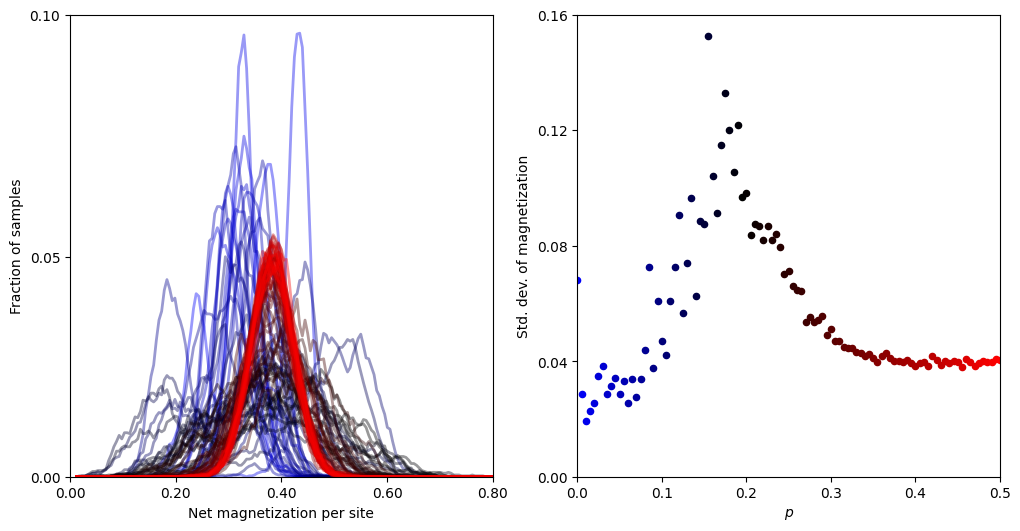

In [24]:
# plotting constants
color='black'
alpha=0.4
linewidth=2
bins = np.linspace(0, 1, 200)

# plotting data
xaxis = (bins[1:] + bins[:-1])/2
window = 5
average_xaxis = [np.mean(xaxis[i : i + window]) for i in range(len(xaxis) - window)]
size=20
# maxstd = 0

# plot
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i in range(len(magnetization_list)):
  histogram_data, bins = np.histogram(magnetization_list[i], bins=bins)
  average_histogram_data = [np.mean(histogram_data[i : i + window]) for i in range(len(histogram_data) - window)]
  average_histogram_data = np.array(average_histogram_data)
  # if maxstd < np.std(magnetization_list[i]):
  #   maxstd = np.std(magnetization_list[i])
  if plist[i] < 0.2:
    color = [0, 0, 1 - (i + 1) / len(plist[plist < 0.2])]
    # ax[0].plot(xaxis, histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[0].plot(average_xaxis, average_histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[1].scatter([plist[i]], [np.std(magnetization_list[i])], size, color=color)
  else:
    color = [(i + 1 - len(plist[plist < 0.2])) / len(plist[plist >= 0.2]), 0, 0]
    # ax[0].plot(xaxis, histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[0].plot(average_xaxis, average_histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[1].scatter([plist[i]], [np.std(magnetization_list[i])], size, color=color)

# plot formatting
ax[0].set_xticks(np.linspace(0, 0.8, 5))
ax[0].set_xticklabels([format(i, '.2f') for i in np.linspace(0, 0.8, 5)])
ax[0].set_xlim([0.0, 0.80])
ax[0].set_xlabel("Net magnetization per site")
ax[0].set_yticks([0, 50, 105])
ax[0].set_yticklabels([format(i / run_time, '.2f') for i in [0, 50, 105]])
ax[0].set_ylim([0, 105])
ax[0].set_ylabel("Fraction of samples")

ax[1].set_xticks(np.linspace(0, 0.5, 6))
ax[1].set_xticklabels([format(i, '.1f') for i in np.linspace(0, 0.5, 6)])
ax[1].set_xlim([0, 0.5])
ax[1].set_xlabel(r"$p$")
ax[1].set_yticks(np.linspace(0, 0.16, 5))
ax[1].set_yticklabels([format(i, '.2f') for i in np.linspace(0, 0.16, 5)])
ax[1].set_ylim([0, 0.16])
ax[1].set_ylabel("Std. dev. of magnetization")
plt.show()